In [1]:
#bsub -nnodes 4 -Ip -XF -W 600 /bin/bash
#!lrun -T1 hostname | sort | awk '{print $1}'| sed "s/^/'/;s/$/',/"
#!bjobs -X

In [15]:
allocated_hosts = ['lassen190','lassen190',
'lassen556',
'lassen579',
'lassen676']
allocated_hosts_str = " ".join(allocated_hosts)
print(allocated_hosts_str)

lassen190 lassen190 lassen556 lassen579 lassen676


In [16]:
for host in allocated_hosts:
    print("ssh ",host," \"ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9\"; ", end="")

ssh  lassen190  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen190  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen556  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen579  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; ssh  lassen676  "ps -aef | grep dask | grep -v grep | awk {'print \$2'} | xargs kill -9"; 

In [17]:
import math
num_cores = 16
workers_per_node = 4
threads_per_worker = int(math.floor(num_cores / workers_per_node))
memory_per_worker = int(math.floor(256/workers_per_node))
print(workers_per_node,threads_per_worker,memory_per_worker )

4 4 64


In [18]:
from dask.distributed import SSHCluster
cluster = SSHCluster(
    allocated_hosts,
    connect_options={"known_hosts": None},
    worker_options={"nthreads": threads_per_worker, 'nprocs':workers_per_node, 'memory_limit': '{}GB'.format(memory_per_worker), "local_directory":'/tmp/haridev'},
    scheduler_options={"port": 8780, "dashboard_address": ":8797"}  
)

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at: tcp://192.168.128.190:8780
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.128.190:43717'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.128.190:45915'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.128.190:43353'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.128.190:37099'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://192.168.130.168:33131'
distributed.deploy.ssh - IN

In [19]:
#cluster.close()

In [20]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np

In [21]:
#cluster = LocalCluster()

In [22]:
#client = Client(cluster)
client = Client("{}:8780".format(allocated_hosts[0]))

In [23]:
client

<Client: 'tcp://192.168.128.190:8780' processes=16 threads=64, memory=0.93 TiB>

In [24]:
#client.shutdown()
#cluster.close()

In [25]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [26]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

In [27]:
parquet_folder="/p/gpfs1/haridev/parquet/lbann-atom-32-trace-3"

In [28]:
num_ranks = 128

In [29]:
#client.restart()

### process dataset per rank

In [30]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [31]:
ddf.npartitions

128

In [32]:
#client.cancel(ddf)

In [33]:
ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [34]:
#ddf[0].head()

In [35]:
ddf = ddf[ddf['level'] == 0]
#ddf = ddf.persist()

In [36]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

In [37]:
io_ddf.columns

Index(['index', 'rank', 'thread_id', 'cat', 'tstart', 'tend', 'func_id',
       'level', 'arg_count', 'args_1', 'args_2', 'args_3', 'args_4', 'args_5',
       'args_6', 'args_7', 'args_8', 'args_9', 'args_10'],
      dtype='object')

In [38]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

In [39]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

In [40]:
io_ddf['size'] = "0"
io_ddf['count'] = "1"
io_ddf['size'] = io_ddf['size'].mask(read_condition , io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fread_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fread_condition, io_ddf['args_2'])
io_ddf['size'] = io_ddf['size'].mask(write_condition, io_ddf['args_3'])
io_ddf['size'] = io_ddf['size'].mask(fwrite_condition, io_ddf['args_3'])
io_ddf['count'] = io_ddf['count'].mask(fwrite_condition, io_ddf['args_2'])

In [41]:
io_ddf['size'] = io_ddf['size'].mask(readdir_condition , "0")
io_ddf['count'] = io_ddf['count'].mask(readdir_condition , "1")

In [42]:
dd.compute(io_ddf['size'].unique(),io_ddf['count'].unique())

(0           0
 1        8192
 2       16384
 3         193
 4           1
 5    16777216
 6          35
 7          33
 8          34
 Name: size, dtype: object,
 0    1
 Name: count, dtype: object)

In [43]:
io_ddf = io_ddf.astype({'size': 'int32','count': 'int32'})

In [44]:
io_ddf['size'] = io_ddf['size'] * io_ddf['count']

In [45]:
filenames = dd.compute(io_ddf[io_ddf['filename'].str.contains('/p/gpfs1/brain')]['filename'].unique())

In [46]:
filenames = filenames[0].to_numpy()

In [47]:
for filename in filenames:
    print(filename)

/p/gpfs1/brainusr/datasets/zinc/moses_zinc_train250K.npy


In [48]:
file_df = io_ddf[io_ddf['filename'].isin(filenames)][['rank','filename','size', 'tstart', 'tend']].compute()

In [49]:
file_df['bandwidth'] = file_df['size']*1.0/(file_df['tend'] - file_df['tstart'])/1024.0/1024.0

In [50]:
file_df

,rank,filename,size,tstart,tend,bandwidth
1547,0,/p/gpfs1/brainusr/datasets/zinc/moses_zinc_tra...,0,22.252127,22.252182,0.000000
1550,0,/p/gpfs1/brainusr/datasets/zinc/moses_zinc_tra...,16777216,22.252283,22.324915,220.289076
1551,0,/p/gpfs1/brainusr/datasets/zinc/moses_zinc_tra...,16777216,22.524570,22.592735,234.725166
1552,0,/p/gpfs1/brainusr/datasets/zinc/moses_zinc_tra...,16777216,22.788328,22.791039,5903.313160
1553,0,/p/gpfs1/brainusr/datasets/zinc/moses_zinc_tra...,16777216,22.978256,22.981451,5008.124179
...,...,...,...,...,...,...
1655,127,/p/gpfs1/brainusr/datasets/zinc/moses_zinc_tra...,16777216,22.792118,22.795048,5461.333333
1656,127,/p/gpfs1/brainusr/datasets/zinc/moses_zinc_tra...,16777216,22.999311,23.002176,5584.958722
1657,127,/p/gpfs1/brainusr/datasets/zinc/moses_zinc_tra...,16777216,23.214647,23.218426,4234.532055
1658,127,/p/gpfs1/brainusr/datasets/zinc/moses_zinc_tra...,16777216,23.442516,23.444708,7300.790252


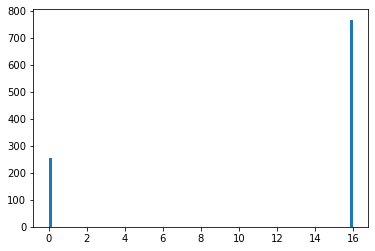

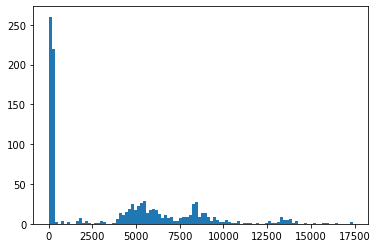

In [51]:
for filename in filenames:
    file_df_temp = file_df[file_df['filename'] == filename] 
    file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    plt.hist(file_sizes, bins=100)
    plt.show()
    plt.hist(file_df_temp['bandwidth'].to_numpy(), bins=100)
    plt.show()